In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#some of blocks below are not used.

# Data manipulation
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt

# Fastai
from fastai.vision import *
from fastai.vision.models import *

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset 

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
#import pretrainedmodels
import torchvision.models as models

from pathlib import Path
import sys

from glob import glob
from PIL import Image

In [ ]:
np.random.seed(42)

BATCH_SIZE= 25
NUMBER_EPOCHS=60
IMG_SIZE=100

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        model = models.densenet161(pretrained=True)

        #Freezing
        for param in model.parameters():
          param.require_grad = False

        #Estrazione blocco convoluzionale
        self.cnn1 = torch.nn.Sequential(*(list(model.children())[:-1]))

        #Aggiungo nuovi layers pienamente connessi
        model.classifier = nn.Sequential(
            nn.Linear(39744, 460),
            nn.ReLU(),
            nn.Linear(460,4),            
        )

        self.fc = model.classifier 
        

    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        
        output = torch.cat((output1, output2),1)
        #print(output.shape) #è l'output che deve aver il primo fc
        output = self.fc(output)
        return output

In [ ]:
class testDataset(Dataset): 
    
    def __init__(self,relationships, transform=None):
        self.relationships = relationships 
        self.transform = transform
        
        
    def __getitem__(self,index):
        row = test_set[index]

        #print("riga: ",row)

        img0_path = "/content/drive/MyDrive/kinship project/input/Ignoti/test/"+row[0]+".png"
        img1_path = "/content/drive/MyDrive/kinship project/input/Ignoti/test/"+row[1]+".png"

        

        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , row[2] 

    def __len__(self):
        return len(self.relationships)
    


In [ ]:
#importa csv con relazione
test_df  = pd.read_csv("/content/drive/MyDrive/kinship project/input/Ignoti/IgnotiRel.CSV")
test_df.head(20)
test_set = test_df.to_numpy() 


In [ ]:
testset = testDataset( relationships = test_set,  transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))

testloader = DataLoader(testset,
                        shuffle= False,
                        num_workers=0,
                        batch_size=1)#Both extra workers and batch size lead to data out of order, the submission.csv will be out of order
#if you have better method, please tell me! thanks a lot!

In [ ]:

#Carica un modello con i pesi pre-salvati
PATH = "/content/drive/MyDrive/kinship project/input/densenetSplit1245.pth"
model  = torch.load(PATH)

net = model.cuda()

In [ ]:
predictions=[]
etichette = []
correct_val = 0
total = 0

with torch.no_grad():
    for data in testloader:
        img0, img1, labels = data
        img0, img1, labels = img0.cuda(), img1.cuda(), labels.cuda()
        outputs = net(img0,img1)
        _, predicted = torch.max(outputs, 1)
        predictions = np.concatenate((predictions,predicted.cpu().numpy()),0)#taking care of here, the output data format is important for transfer

        correct_val += (predicted == labels).sum().item()
        total += labels.size(0)


print(f"Accuratezza del modello: {float(correct_val)/float(total)*100:.2f}")

test_df['Predizione'] = predictions
test_df.to_csv("/content/drive/MyDrive/kinship project/input/MyPredictionIgnoti1245.csv", index=False)#submission.csv should be placed directly in current fold.
test_df.head(300)#show the result to be committed

Accuratezza del modello: 90.00


,img1,img2,Parentela,Predizione
0,1Aprile[1]1,1Aprile[1]2,1,1.0
1,4Aprile[8]3,4Aprile[8]1,0,0.0
2,9Aprile[8]3,9Aprile[8]1,1,1.0
3,11Aprile[2]3,11Aprile[2]2,2,2.0
4,14Aprile[7]2,14Aprile[7]1,0,0.0
5,16Aprile[3]1,16Aprile[3]2,0,0.0
6,18Aprile[6]1,18Aprile[6]2,2,2.0
7,19Aprile[3]3,19Aprile[3]2,2,2.0
8,20Aprile[2]2,20Aprile[2]3,1,0.0
9,23Aprile[5]3,23Aprile[5]1,0,0.0


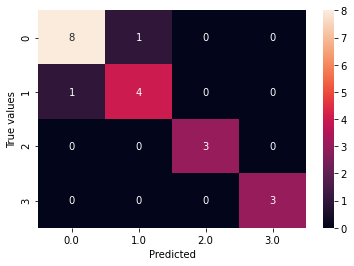

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

#creazione matrice di confusione
confusion_matrix = pd.crosstab(test_df['Parentela'], test_df['Predizione'], rownames=['True values'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()